In [1]:
# Math, image processing and other useful libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os
import pandas as pd
import numpy as np
import cv2
from collections import OrderedDict
import copy
import math
import pickle
from matplotlib.ticker import MaxNLocator
from itertools import combinations

# Image processing
from skimage.measure import regionprops
from skimage.filters import meijering, sato, frangi, hessian, threshold_otsu
from skimage.morphology import extrema, skeletonize
from skimage.transform import probabilistic_hough_line
from skimage.draw import disk, circle_perimeter
from scipy.ndimage import gaussian_filter, grey_closing
from scipy.spatial import distance_matrix
from skimage import data, restoration, util
from roipoly import RoiPoly
from matplotlib_scalebar.scalebar import ScaleBar
from biosppy.signals import tools
from biosppy.stats import pearson_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import matplotlib.colors as colors
import seaborn as sns

# Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

# Nuclei Segmentation
from auxiliary_functions_segmentation import segment_patches

# Feature Extraction (.py files by Teresa Parreira)
# from CytoSkeletonPropsMorph import CytoSkeletonPropsMorph
# from CytoSkeletonRegionPropsInt import RegionPropsInt
# from FreqAnalysis import FreqAnalysis
# from GLCM import GLCM

# 
from Functions import label_image, FeaturesFromCentroid, cv2toski,pylsdtoski,init_import,polar_to_cartesian, truncate_colormap, plot_hist, plot_pie, remove_not1D,  quantitative_analysis,hist_bin,hist_lim 
from fractal_dimension import fractal_dimension
from fractal_analysis_fxns import boxcount,boxcount_grayscale,fractal_dimension,fractal_dimension_grayscale,fractal_dimension_grayscale_DBC

C:\Users\diogo\AppData\Roaming\Python\Python37\site-packages\nose\importer.py:12: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import find_module, load_module, acquire_lock, release_lock


In [4]:
z = np.zeros((2*radius,2*radius))
plt.imshow(z,cmap='gray')
circle = plt.Circle((radius,radius), radius, fill=True, color = 'w')
plt.gcf().gca().add_artist(circle)

NameError: name 'radius' is not defined

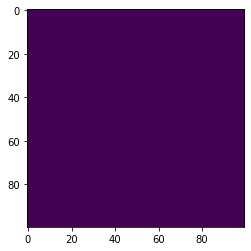

In [30]:
plt.imshow(z)

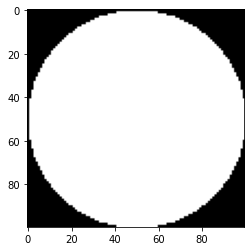

In [33]:
radius = 50
rr, cc = disk((radius,radius), int(radius))
disk_pixels_  = list(zip(rr,cc))
z = np.zeros((2*radius,2*radius))
z[rr,cc] = 1
plt.imshow(z,cmap='gray')

In [79]:
help(ellipse)

Help on function ellipse in module skimage.draw.draw:

ellipse(r, c, r_radius, c_radius, shape=None, rotation=0.0)
    Generate coordinates of pixels within ellipse.
    
    Parameters
    ----------
    r, c : double
        Centre coordinate of ellipse.
    r_radius, c_radius : double
        Minor and major semi-axes. ``(r/r_radius)**2 + (c/c_radius)**2 = 1``.
    shape : tuple, optional
        Image shape which is used to determine the maximum extent of output pixel
        coordinates. This is useful for ellipses which exceed the image size.
        By default the full extent of the ellipse are used. Must be at least
        length 2. Only the first two values are used to determine the extent.
    rotation : float, optional (default 0.)
        Set the ellipse rotation (rotation) in range (-PI, PI)
        in contra clock wise direction, so PI/2 degree means swap ellipse axis
    
    Returns
    -------
    rr, cc : ndarray of int
        Pixel coordinates of ellipse.
        M

In [ ]:
rr, cc = disk((cell_size,cell_size), cell_size)

In [2]:
import random
from skimage.draw import ellipse
def createsynthetic(N_lines,cell_size,cell_type,angle_type,mu,sigma,membrane):
    global angle,length,offset,pos1,pos2,lines,pixels,pixels_mic,pixels_membrane,mask
    
    #center = int(cell_size + /2),int(cell_size/2)
    off = 5
    
    if cell_type == 'round':
        rr, cc = disk((cell_size+off,cell_size+off), cell_size)
        z = np.zeros((2*cell_size+2*off,2*cell_size+2*off))
        pixels = list(zip(rr,cc))
        #z[rr,cc] = 1
        #plt.imshow(z,cmap='gray')
        
        if type(membrane) == tuple:
            rr_mic,cc_mic = disk((cell_size+off,cell_size+off), cell_size-membrane[0])
            #z_mic = np.zeros((2*cell_size+2*off,2*cell_size+2*off))
            pixels_mic = list(zip(rr_mic,cc_mic))
            pixels_membrane = list(set(pixels) - set(pixels_mic))
            
    if cell_type == 'ellipse':
        rr, cc = ellipse(cell_size[0],cell_size[1], cell_size[0],cell_size[1],rotation=cell_size[2])
        z = np.zeros((2*cell_size[1]+2*off,2*cell_size[1]+2*off))
        
    if cell_type == 'draw':
        figROI,axROI = plt.subplots(figsize=(30,30))
        z = np.zeros((cell_size[0],cell_size[0]))
        plt.imshow(z,cmap='gray')
        plt.axis('off')
        plt.title('Draw Cell Contour/Shape')
        
        # Define ROI
        ROI = RoiPoly(color='r')
        #ROI.display_roi()
        
        mask = ROI.get_mask(z)
        pixels = list(zip(np.where(mask != 0)[1],np.where(mask != 0)[0]))

    
    # Create lines
    lines = []
    n     = 0
    while n < N_lines:
        if angle_type == 'uniform':
            angle  = np.random.uniform(-np.pi,np.pi,1)
        if angle_type == 'normal':
            angle  = np.random.normal(3*np.pi/180,10*np.pi/180,1)
        length = np.random.normal(mu, sigma, 1)
        offset = random.choice(pixels)
        pos1,pos2 = get_line(length,angle)
        #if (int(pos1) in rr and int(pos2) in cc) or (int(pos1) in cc and int(pos2) in rr):
        if (int(pos1[0] + offset[0]),int(pos1[1] + offset[1])) in pixels and (int(pos2[0] + offset[0]),int(pos2[1] + offset[1])) in pixels:
            lines = lines + [((pos1[0]+offset[0],pos1[1]+offset[1]),(pos2[0] + offset[0],pos2[1]+offset[1]))]
            #lines = lines + [((pos1[0],pos1[1]),(pos2[0],pos2[1]))]
            n = n + 1
    
    if (type(membrane) == tuple):
        n = 0
        while (n < membrane[1]):
            angle  = np.random.uniform(-np.pi,np.pi,1)
            length = np.random.normal(mu, sigma, 1)
            offset = random.choice(pixels_membrane)
            pos1,pos2 = polar2cartesian(length,angle)
            if (int(pos1[0] + offset[0]),int(pos1[1] + offset[1])) in pixels_membrane and (int(pos2[0] + offset[0]),int(pos2[1] + offset[1])) in pixels_membrane:
                lines = lines + [((pos1[0]+offset[0],pos1[1]+offset[1]),(pos2[0] + offset[0],pos2[1]+offset[1]))]
                n = n + 1
        
            
    # Plot
    fig,ax = plt.subplots(figsize=(5,5))
    maxx = int(np.array(lines).max()) 
    minn = int(np.array(lines).min()) 
    #plt.imshow(np.zeros((abs(maxx-minn),abs(maxx-minn))),cmap='gray')
    
    ax.imshow(z,cmap='gray')
        
    for l in lines:
        p0,p1 = l
        ax.plot((p0[0], p1[0]), (p0[1], p1[1]),linewidth=2,color='w')
        
    #plt.axis('off')
    ax.set_ylim([0,z.shape[0]])
    ax.set_xlim([0,z.shape[1]])
    plt.show()
        
    return lines,fig  

print('FUNCTION: createsynthetic(lines)')

FUNCTION: createsynthetic(lines)


In [3]:
def polar_to_cartesian(lines):
    res = []
    lines = lines.reshape((lines.shape[0],lines.shape[2]))
    for i in lines:
        rho,theta = i[0],i[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        res += [((x1,y1),(x2,y2))]
        
    return res

print('FUNCTION: polar_to_cartesian(lines)')

FUNCTION: polar_to_cartesian(lines)


In [4]:
def polar2cartesian(rho,theta):
    global a,b,x0,x1,x1,x2,y1,y2
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1*(-b))
    y1 = int(y0 + 1*(a))
    x2 = int(x0 - 1*(-b))
    y2 = int(y0 - 1*(a))
    return (x1,y1),(x2,y2)

print('FUNCTION: polar2cartesian(rho,theta)')

FUNCTION: polar2cartesian(rho,theta)


In [5]:
def get_line(length,theta):
    pos1 = (0,0)
    a = np.cos(theta)
    b = np.sin(theta)
    posx = a*length
    posy = b*length
    return (0,0),(posx,posy)

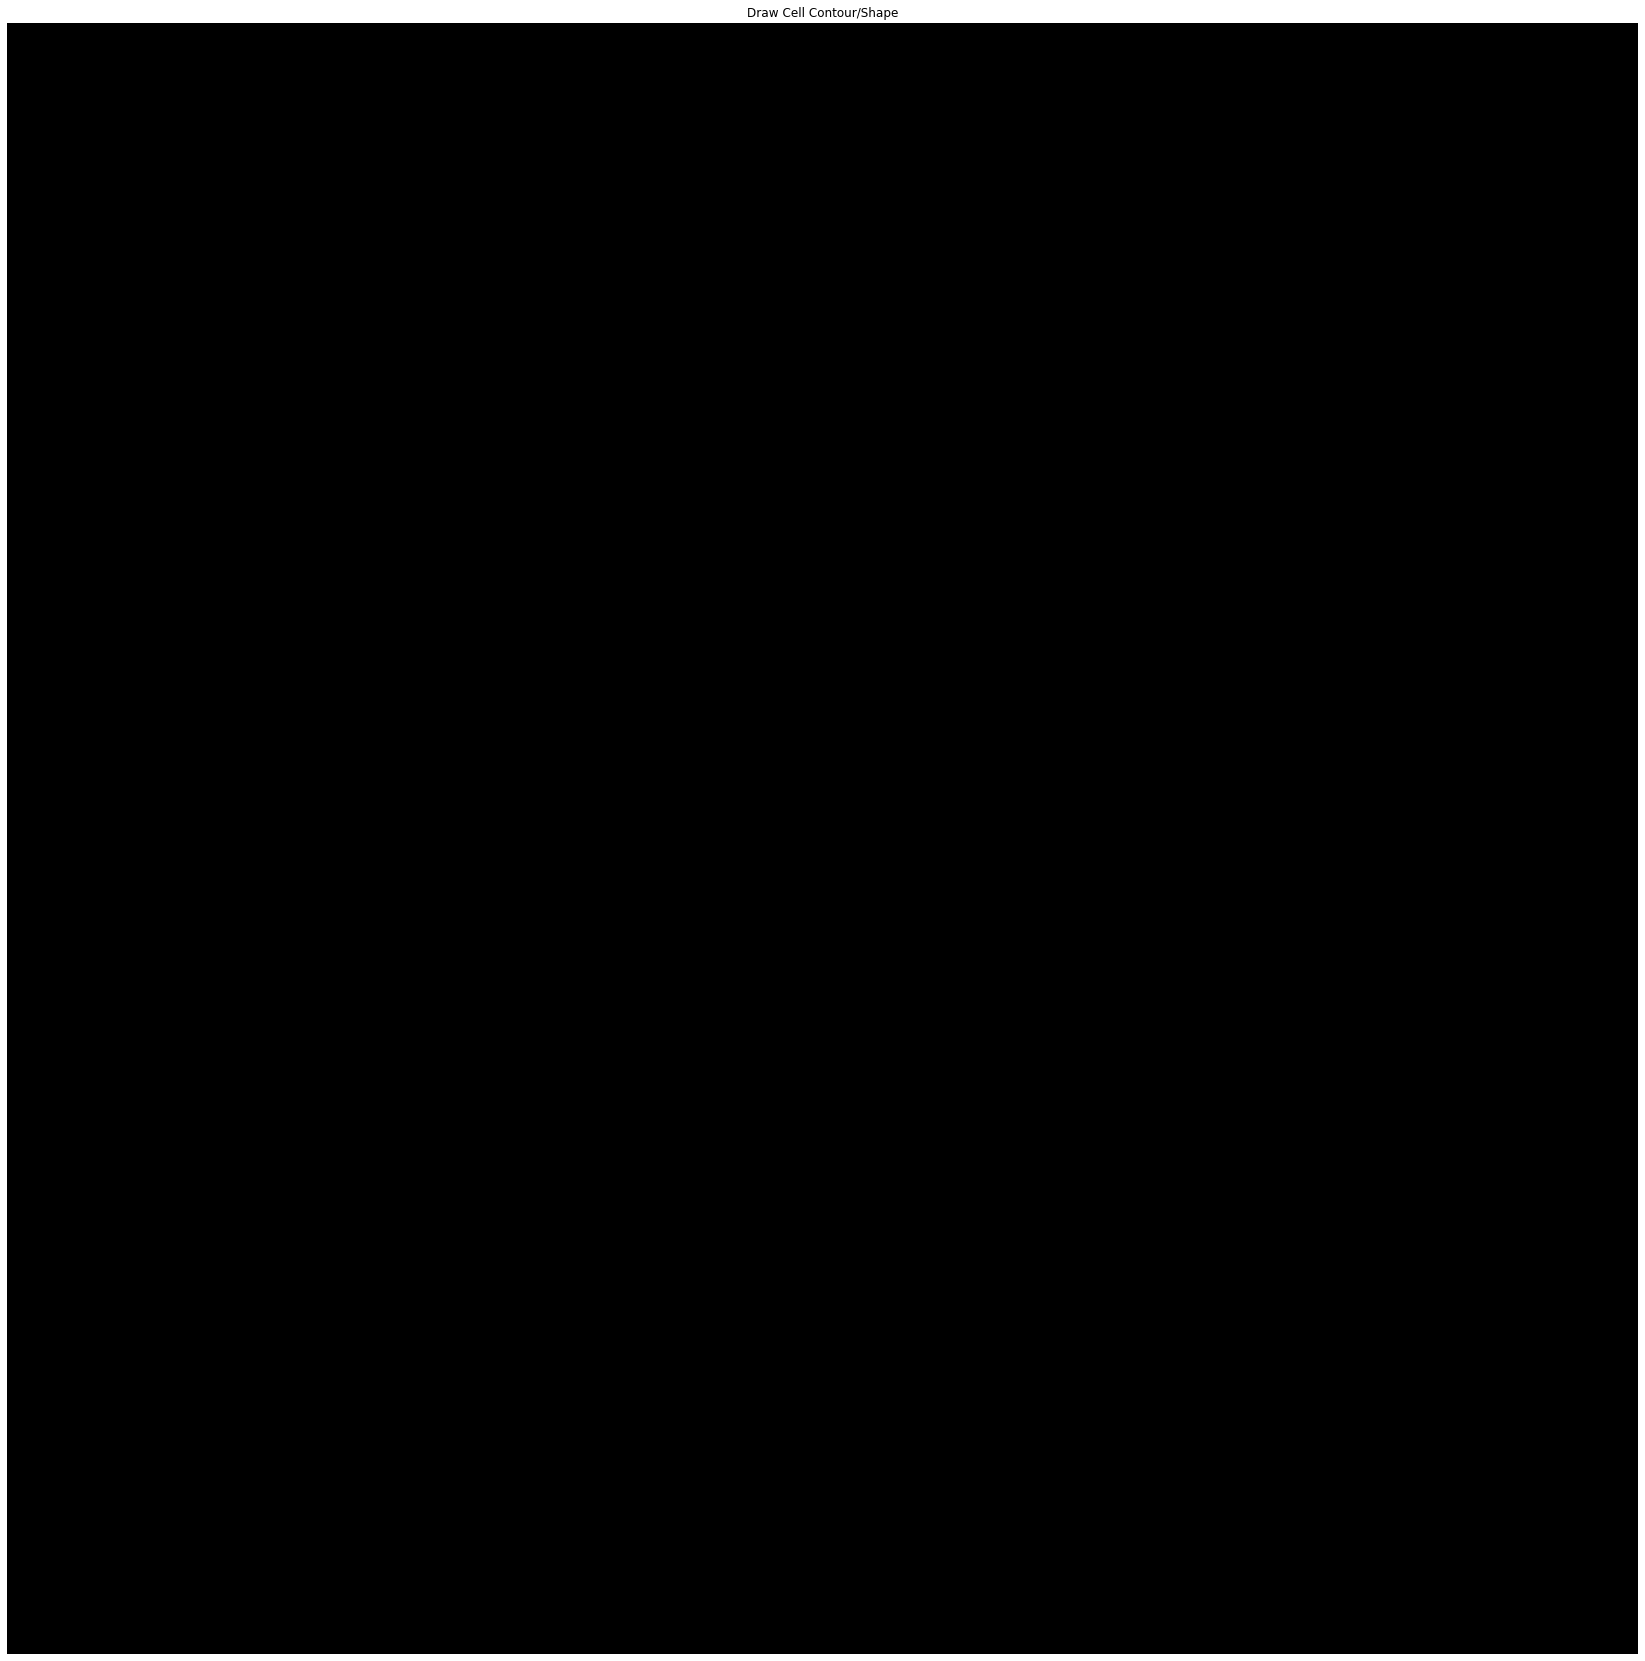

IndexError: list index out of range

In [7]:
%matplotlib inline
#lines,fig = createsynthetic(N_lines=100,cell_size=50,cell_type='round',angle_type='normal',mu=6,sigma=1,membrane=(8,10))
lines,fig = createsynthetic(N_lines=100,cell_size=[50],cell_type='draw',angle_type='normal',mu=6,sigma=1,membrane=False)
#lines = createsynthetic(N_lines=200,cell_size=(10,80,0),cell_type='ellipse',mu=4,sigma=1,membrane=False)

# membrane: False or (thickness,number of lines)
# cell_size: (int) radius for round cells, (minor axis,major axis,rotation) for ellipse cells, (int) radius for draw
# angle_type: uniform or normal
# noise: add poisson noise

In [29]:
plt.imshow(mask)

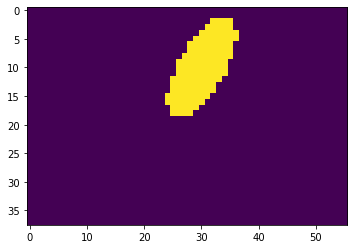

In [21]:
from skimage.draw import ellipse
off = 5
rr, cc = ellipse(20,40, 4,10,rotation=np.pi/3)
z = np.zeros((np.max(rr) + 2*off,np.max(cc) + 2*off))
z[rr-2*off,cc-2*off] = 1
plt.imshow(z)

In [223]:
fig.patch

In [224]:
help(ax)

Help on Figure in module matplotlib.figure object:

class Figure(FigureBase)
 |  Figure(figsize=None, dpi=None, facecolor=None, edgecolor=None, linewidth=0.0, frameon=None, subplotpars=None, tight_layout=None, constrained_layout=None, *, layout=None, **kwargs)
 |  
 |  The top level container for all the plot elements.
 |  
 |  The Figure instance supports callbacks through a *callbacks* attribute
 |  which is a `.CallbackRegistry` instance.  The events you can connect to
 |  are 'dpi_changed', and the callback will be called with ``func(fig)`` where
 |  fig is the `Figure` instance.
 |  
 |  Attributes
 |  ----------
 |  patch
 |      The `.Rectangle` instance representing the figure background patch.
 |  
 |  suppressComposite
 |      For multiple images, the figure will make composite images
 |      depending on the renderer option_image_nocomposite function.  If
 |      *suppressComposite* is a boolean, this will override the renderer.
 |  
 |  Method resolution order:
 |      Figu

In [ ]:
lsd   = cv2.createLineSegmentDetector(cv2.LSD_REFINE_ADV,2.5,0.001,0,90,-200,0.5,2048)
lines = cv2toski(lsd.detect((patch * 255).astype(np.uint8))[0])
    

In [125]:
[1,2,3,4].symmetric_difference([1,2])

AttributeError: 'list' object has no attribute 'symmetric_difference'

In [112]:
createsynthetic(50,50,'round',)

TypeError: createsynthetic() missing 2 required positional arguments: 'mu' and 'sigma'

In [5]:
s = np.random.normal(0, 0.1, 1000)

In [87]:
np.array(lines).min()

-32.887237260930696